In [4]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("aoe4_data.csv")

In [3]:
df.rename(columns={"Resource Cost": "Food", "Unnamed: 4": "Wood","Unnamed: 5": "Gold",}, inplace=True)
df.rename(columns={"Unnamed: 15" :"Spd","Unnamed: 16": "DPS","Unnamed: 17": "Rng"},inplace =True)
df.drop(columns=["Unnamed: 1", "Unnamed: 2","Bonus","Note","Unnamed: 19","Unnamed: 18","Unnamed: 13","Unnamed: 6","Move", "DPS", "HP per\nResource"], inplace=True)
df.rename(columns={" ": "Names"}, inplace=True)
df = df.iloc[:107]
df = df.dropna(subset=['Food', 'Gold', 'Wood'])
# we also drop the row where the unit is being listed twice, as it has different attack points to different units,
display(df.loc[df['Names']=="(Tusk)"].index)
display(df.loc[df['Names']=="(Tusk vs Building)"].index)
df = df.drop([50,60,51,61])
df = df.fillna(0)
df.head()

Index([50, 60], dtype='int64')

Index([51, 61], dtype='int64')

,Names,Food,Wood,Gold,Time,Pop,HP,Armor,Attack,Spd,Rng
2,Spearman,60.0,20.0,0.0,15.0,1.0,70.0,0,6,1.75,0.29
6,Landsknecht,60.0,0.0,100.0,22.0,1.0,80.0,0,17,1.25,0.29
9,Man-at-Arms,100.0,0.0,20.0,22.0,1.0,100.0,2,8,1.25,0.29
13,Palace Guard,100.0,0.0,20.0,22.0,1.0,155.0,3,12,1.25,0.29
16,Archer,30.0,50.0,0.0,15.0,1.0,70.0,0,5,1.5,5.00


In [27]:
# 100 wood is 130 gold
# 100 food is 130 gold
df.Food *= 1.3
df.Wood *= 1.3
df.Gold = df.Food + df.Wood + df.Gold
df.drop(columns=["Food", "Wood"], inplace=True)
df.head()

,Names,Gold,Time,Pop,HP,Armor,Attack,Spd,Rng
2,Spearman,104.0,15.0,1.0,70.0,0,6,1.75,0.29
6,Landsknecht,178.0,22.0,1.0,80.0,0,17,1.25,0.29
9,Man-at-Arms,150.0,22.0,1.0,100.0,2,8,1.25,0.29
13,Palace Guard,150.0,22.0,1.0,155.0,3,12,1.25,0.29
16,Archer,104.0,15.0,1.0,70.0,0,5,1.5,5.00


In [6]:
# Time, HealthPoint, Population Limit, Armor, Attack, Speed and Range would be our constraints\n",
# Time: total time to train these unit has to be less than certain units of time\n",
# HealthPoint: the total HealthPoint for the units have to be greater than certain threshold\n",
# similar to health points, total Armor, Attack points, speed and range has to be greater than certain threshold\n",
# population limit is the amount of units the country can host, so it has to be less than certain threshold\n",
c = np.array(df['Gold'])
A = np.array(df[['HP','Armor','Attack', "Spd", "Rng"]]).T
T = np.array(df["Time"]).T
P = np.array(df["Pop"]).T
df["Armor"] = df["Armor"].astype(float)
df["Attack"] = df["Attack"].astype(float)
df["Spd"] = df["Spd"].astype(float)
df["Rng"] = df["Rng"].astype(float)
b = np.array([5000,20,1000,100,130]) 
# These are our requirements

In [7]:
X = cp.Variable(df.shape[0])

constraints = [
    A @ X >= b, 
    X >= 0,  
    P @ X <= 200,
    T @ X <= 1536  
]

for i in range(df.shape[0]):
    constraints.append(X[i] <= 0.35 * cp.sum(X))  # No single unit type can exceed 50% of the total population

elite_units = cp.Variable(df.shape[0], boolean=True)
constraints.append(cp.sum(elite_units) >= 0.1 * cp.sum(X))
for i in range(df.shape[0]):
    constraints.append(elite_units[i] * 600 <= c[i])  # Only count units costing >600 as elite

obj = cp.Minimize(c @ X)
prob = cp.Problem(obj, constraints)
prob.solve()


np.float64(133.33333333333334)

In [34]:
print("The Algorithm recommends this composition of Army for your Victory!\n")
for i in range(df.shape[0]):
    unit_name = df.iloc[i, 0] 
    if X.value[i] > 0:
        print(unit_name, ":",abs(X.value.round(1)[i]), "Units")
    if elite_units.value[i] > 0 and X.value[i] > 0:
        print(unit_name, "is the Elite Unit")

The Algorithm recommends this composition of Army for your Victory!

Palace Guard : 6.7 Units
Archer : 17.5 Units
Scout : 14.5 Units
Khan : 3.6 Units
Horse Archer : 3.7 Units
Ram : 4.1 Units


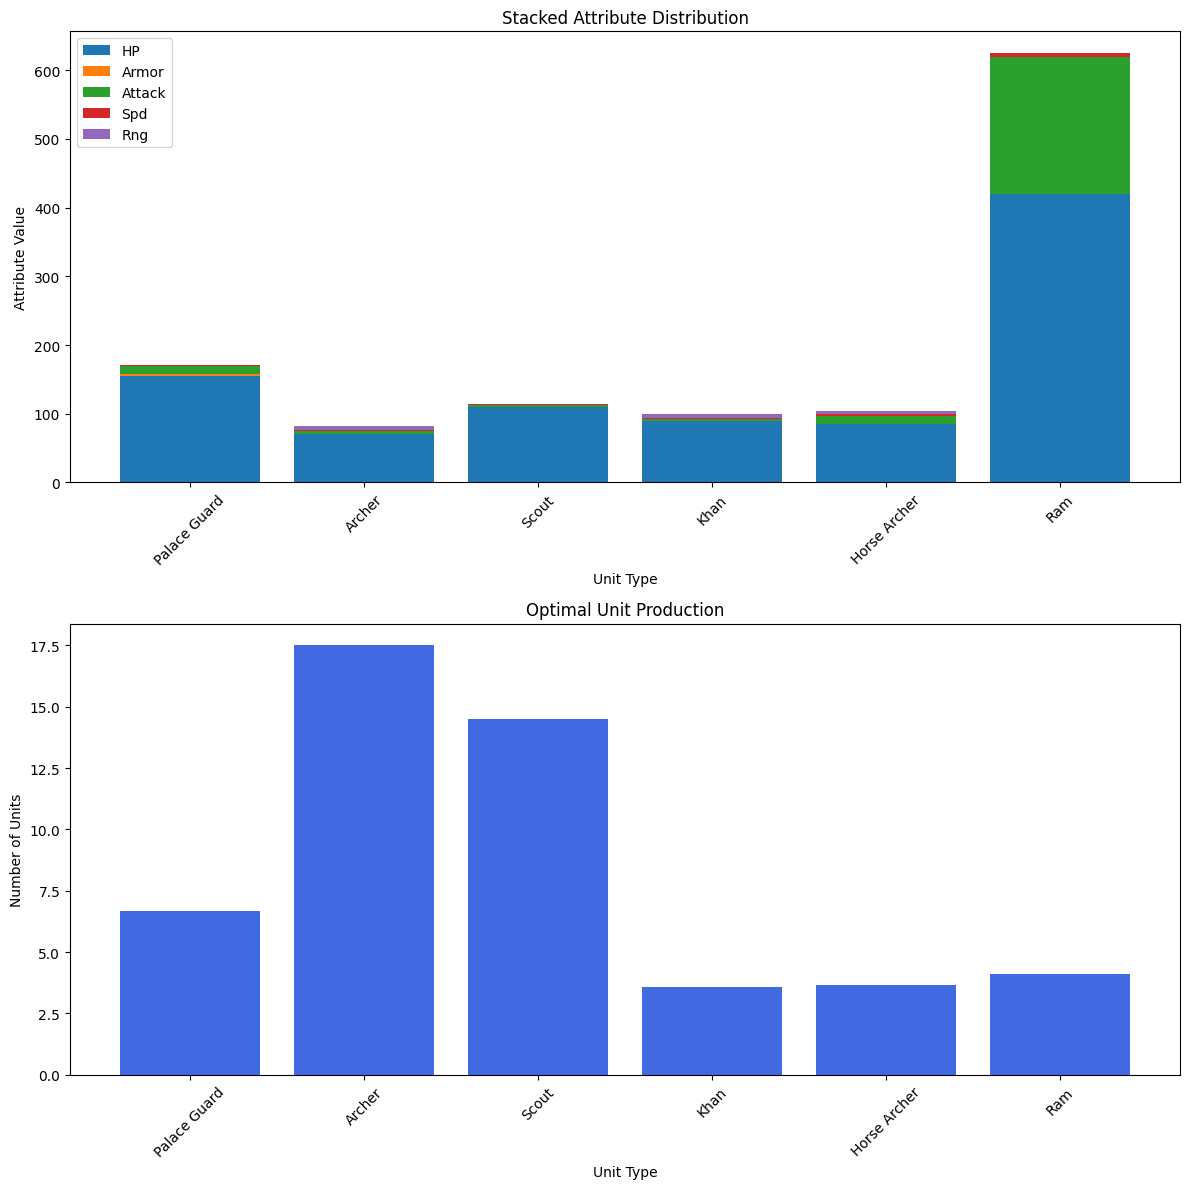

In [36]:
# Ensure X.value is available after solving the optimization problem
produced_units = X.value > 0

# Extract unit names
unit_names = df.loc[produced_units, df.columns[0]]  # Assuming first column contains unit names

# Select attributes and their values
attributes = ['HP', 'Armor', 'Attack','Spd', "Rng"]
attr_values = df.loc[produced_units, attributes].values.T  # Transpose for stacking

# Extract unit counts
unit_counts = X.value[produced_units]

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Stacked Attribute Distribution (First Plot)
bottom = np.zeros(len(unit_names))
for attr, values in zip(attributes, attr_values):
    axes[0].bar(unit_names, values, label=attr, bottom=bottom)
    bottom += values  # Update bottom for next stack

axes[0].set_xlabel("Unit Type")
axes[0].set_ylabel("Attribute Value")
axes[0].set_title("Stacked Attribute Distribution")
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Optimal Unit Production (Second Plot)
axes[1].bar(unit_names, unit_counts, color='royalblue')
axes[1].set_xlabel("Unit Type")
axes[1].set_ylabel("Number of Units")
axes[1].set_title("Optimal Unit Production")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()
